# 6  Parallelization with Dask


In [1]:
from dask.distributed import LocalCluster, Client

#passing the address of the scheduler to a client instance that we are creating 
address = 'tcp://127.0.0.1:35655'
client = Client(address)
client

<Client: 'tcp://127.0.0.1:35655' processes=70 threads=140, memory=400.41 GiB>

In [2]:
import os
import urllib

import dask.dataframe as dd



In [3]:
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3A27e4043d-75eb-4c4f-9427-0d442526c154'

msg = urllib.request.urlretrieve(url, "dg_soil_moisture.csv")

In [4]:
#one task for each chunk, number of chunks is decided by blocksize
fp = os.path.join(os.getcwd(),'dg_soil_moisture.csv')
df = dd.read_csv(fp, blocksize = '20MB' , encoding='ISO-8859-1')
df

,timestamp,year,doy,hour,minute,site,logger,port,sensor,sensorZ,m_soil,unit
npartitions=6,,,,,,,,,,,,
,object,int64,int64,int64,int64,object,object,object,object,int64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
averages = df.groupby('year').mean()
averages

/home/sainsbury/.virtualenvs/scomp/lib/python3.9/site-packages/dask/dataframe/groupby.py:369: FutureWarning: The default value of numeric_only will be changed to False in the future when using dask with pandas 2.0
  warnings.warn(


,doy,hour,minute,sensorZ,m_soil
npartitions=1,,,,,
,float64,float64,float64,float64,float64
,...,...,...,...,...


In [7]:
#have dask actually show the computed values
averages.compute()

,doy,hour,minute,sensorZ,m_soil
year,,,,,
2014,276.852636,11.513992,15.001123,-11.998332,0.273744
2015,186.720383,11.500723,15.000000,-13.047899,0.263738
2016,183.497453,11.499777,14.999858,-15.000009,0.293595
2017,181.414843,11.499381,15.000144,-14.999981,0.266121
2018,201.824077,11.500796,15.000356,-15.435365,0.282395
2019,173.693311,11.498577,15.000000,-15.124516,0.222193
2020,138.806679,11.489825,14.999322,-15.200054,0.252467


In [8]:
import numpy as np

import dask.array as da

#creating a dask array from a 200x500 np arrange
data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))

In [11]:
a.mean()

a.mean().compute()

49999.5

In [12]:
# download red band
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3Aac25a399-b174-41c1-b6d3-09974b161e5a'
msg = urllib.request.urlretrieve(url, "RU_ANS_TR2_FL005M_red.tif")


# download nir band
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3A1762205e-c505-450d-90ed-d4f3e4c302a7'

msg = urllib.request.urlretrieve(url, "RU_ANS_TR2_FL005M_nir.tif")

In [14]:
import rioxarray as rioxr

# read in the file
fp_red = os.path.join(os.getcwd(),"RU_ANS_TR2_FL005M_red.tif")
red = rioxr.open_rasterio(fp_red, chunks = '15MB')

In [17]:
# getting rid of unnecessary dimension
red = red.squeeze()
red

<xarray.DataArray (y: 3499, x: 7443)>
dask.array<getitem, shape=(3499, 7443), dtype=float32, chunksize=(1936, 1936), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 6.22e+05 6.22e+05 6.22e+05 ... 6.224e+05 6.224e+05
  * y            (y) float64 7.525e+06 7.525e+06 ... 7.525e+06 7.525e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -10000.0
    scale_factor:  1.0
    add_offset:    0.0

In [16]:
# open data
fp_nir = os.path.join(os.getcwd(),"RU_ANS_TR2_FL005M_nir.tif")
nir = rioxr.open_rasterio(fp_nir, chunks = '15MB')

#squeeze
nir = nir.squeeze()

In [18]:
ndvi = (nir - red) / (nir + red)

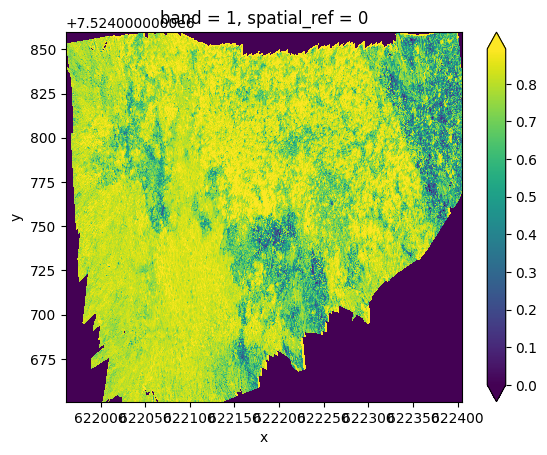

2023-03-28 12:03:58,317 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [19]:
ndvi_values = ndvi.compute()

ndvi_values.plot(robust=True)